In [1]:
import os


!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/

# Set permissions for the json file
!chmod 600 ~/.kaggle/kaggle.json




! kaggle datasets download msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.69GB/s]


In [2]:
! unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split




# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, GlobalAveragePooling2D, SeparableConv2D, Multiply,Lambda
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, VGG16, ResNet50, DenseNet121, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import warnings
warnings.filterwarnings('ignore')

In [4]:
# img_shape = 48
# batch_size = 64
# train_data_path = '../input/fer2013/train/'
# test_data_path = '../input/fer2013/test/'

IMAGE_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 100

TRAIN_PATH = "/content/train"
TEST_PATH = "/content/test"
SELECTED_CLASSES = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
train_preprocessor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

test_preprocessor = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_preprocessor.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    classes=SELECTED_CLASSES,
    shuffle=True
)

# Create validation generator
validation_generator = train_preprocessor.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    classes=SELECTED_CLASSES,
    shuffle=False
)

# Create test generator
test_generator = test_preprocessor.flow_from_directory(
    TEST_PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=SELECTED_CLASSES
)

print("\n✅ Data generators created successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.

✅ Data generators created successfully!
Training samples: 22619
Validation samples: 5654
Test samples: 7067


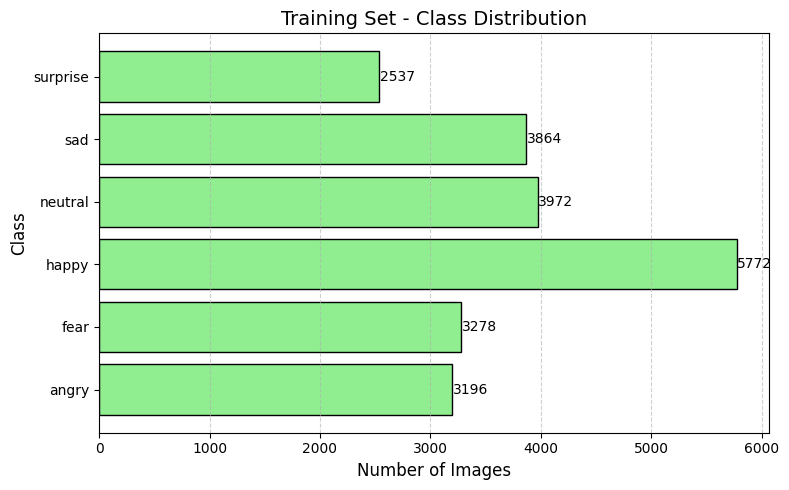

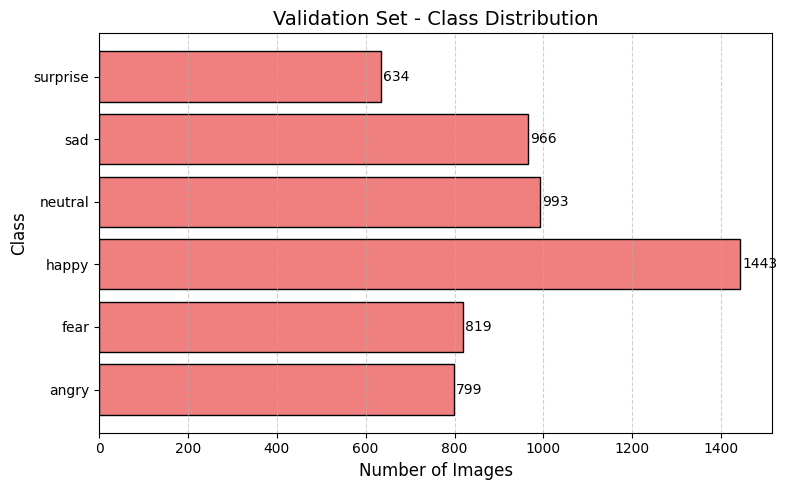

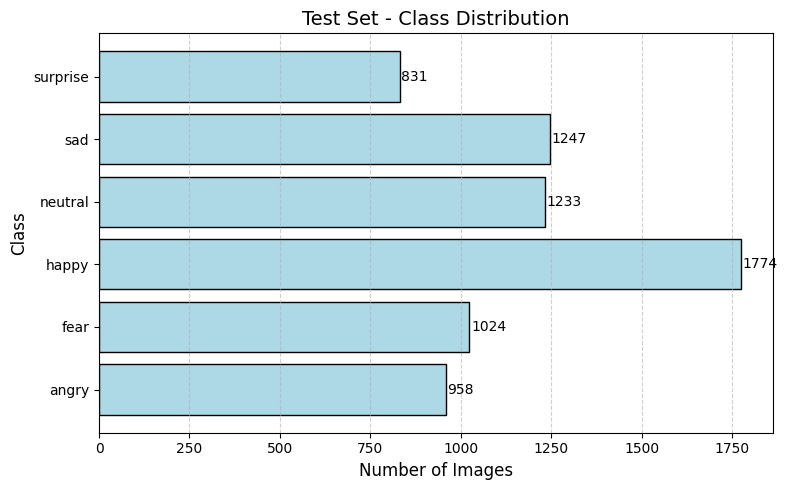

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_class_distribution(data_gen, dataset_name="Dataset", color='skyblue'):

    # Extract class indices and labels
    class_indices = data_gen.class_indices
    class_labels = list(class_indices.keys())
    class_counts = pd.Series(data_gen.classes).value_counts().sort_index()

    # Match labels to their counts
    class_counts.index = [class_labels[i] for i in class_counts.index]

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.barh(class_counts.index, class_counts.values, color=color, edgecolor='black')
    plt.title(f"{dataset_name} - Class Distribution", fontsize=14)
    plt.xlabel("Number of Images", fontsize=12)
    plt.ylabel("Class", fontsize=12)

    # Annotate bar values
    for bar in bars:
        plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
                 f"{int(bar.get_width())}", va='center', fontsize=10)

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
visualize_class_distribution(train_generator, "Training Set", color='lightgreen')
visualize_class_distribution(validation_generator, "Validation Set", color='lightcoral')
visualize_class_distribution(test_generator, "Test Set", color='lightblue')


# EfficientNetB0 (pretrained) + custom CNN

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Input, Lambda, Conv2D, BatchNormalization, MaxPool2D, Dropout,
    GlobalAveragePooling2D, Flatten, Dense, Concatenate, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

def model_hybrid_efficientnet_custom(input_shape, num_classes,
                                     efficientnet_weights='imagenet',
                                     freeze_base=True,
                                     unfreeze_last_n=20,
                                     l2_reg=0.01):
    """
    Hybrid model: EfficientNetB0 (pretrained) + custom CNN branch.
    - input_shape: tuple, e.g. (48,48,1) for grayscale
    - num_classes: integer (e.g. 7)
    - efficientnet_weights: 'imagenet' or None
    - freeze_base: if True, freeze the EfficientNet base initially
    - unfreeze_last_n: after building, unfreeze the last `n` layers of EfficientNet for fine-tuning
    - l2_reg: L2 regularization factor applied on deeper custom conv layers
    Returns: keras Model (not compiled)
    """
    # ---- Input & grayscale -> 3-channel conversion (keeps style from your notebook) ----
    inputs = Input(shape=input_shape)

    # If single-channel, repeat to make 3 channels for pretrained backbone
    if input_shape[-1] == 1:
        x3 = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)
    else:
        x3 = inputs

    # ---- EfficientNetB0 branch (pretrained) ----
    base_model = EfficientNetB0(
        weights=efficientnet_weights,
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Attach EfficientNet to our input (use the converted 3-channel input)
    # Note: using functional API to tie base_model to our `x3` tensor
    enet_out = base_model(x3)
    enet_out = GlobalAveragePooling2D()(enet_out)  # compact global features

    # ---- Custom CNN branch (kept similar to your original custom architecture) ----
    # Block 1
    c = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    c = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    # Block 2
    c = Conv2D(128, kernel_size=(5,5), padding='same', activation='relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    # Block 3 (with L2)
    c = Conv2D(512, kernel_size=(3,3), padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(l2_reg))(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    # Block 4 (with L2)
    c = Conv2D(512, kernel_size=(3,3), padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(l2_reg))(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    c = Flatten()(c)

    # small dense head for custom branch
    c = Dense(256, activation='relu')(c)
    c = BatchNormalization()(c)
    c = Dropout(0.25)(c)

    c = Dense(512, activation='relu')(c)
    c = BatchNormalization()(c)
    c = Dropout(0.25)(c)

    # ---- Feature fusion ----
    merged = Concatenate()([enet_out, c])

    # Classifier head (similar style to other models in your notebook)
    x = Dense(512, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # ---- Fine-tuning logic (match your notebook style) ----
    if freeze_base:
        base_model.trainable = False
    else:
        base_model.trainable = True

    # If user requested to unfreeze the last `unfreeze_last_n` layers of EfficientNet:
    if unfreeze_last_n and unfreeze_last_n > 0:
        base_model.trainable = True
        # freeze all then unfreeze last `unfreeze_last_n` layers
        for layer in base_model.layers[:-unfreeze_last_n]:
            layer.trainable = False
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    return model


In [ ]:
print("Building hybrid EfficientNet + Custom CNN model...")
hybrid_model = model_hybrid_efficientnet_custom((48,48,1), len(SELECTED_CLASSES),
                                                efficientnet_weights='imagenet',
                                                freeze_base=True,
                                                unfreeze_last_n=20,
                                                l2_reg=0.01)

hybrid_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Building hybrid EfficientNet + Custom CNN model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step



TRAINING HYBRID EFFICIENTNET + CUSTOM CNN MODEL
Epoch 1/100
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1862 - loss: 9.5684
Epoch 1: val_accuracy improved from -inf to 0.19225, saving model to best_hybrid_efficientnet_custom_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 110s 100ms/step - accuracy: 0.1862 - loss: 9.5677 - val_accuracy: 0.1923 - val_loss: 8.3664 - learning_rate: 1.0000e-04
Epoch 2/100
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1930 - loss: 8.4615
Epoch 2: val_accuracy improved from 0.19225 to 0.22197, saving model to best_hybrid_efficientnet_custom_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.1930 - loss: 8.4606 - val_accuracy: 0.2220 - val_loss: 7.2245 - learning_rate: 1.0000e-04
Epoch 3/100
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2071 - loss: 7.2032
Epoch 3: val_accuracy improved from 0.22197 to 0.25929, saving model to best_hybrid_efficientnet_custom_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - a

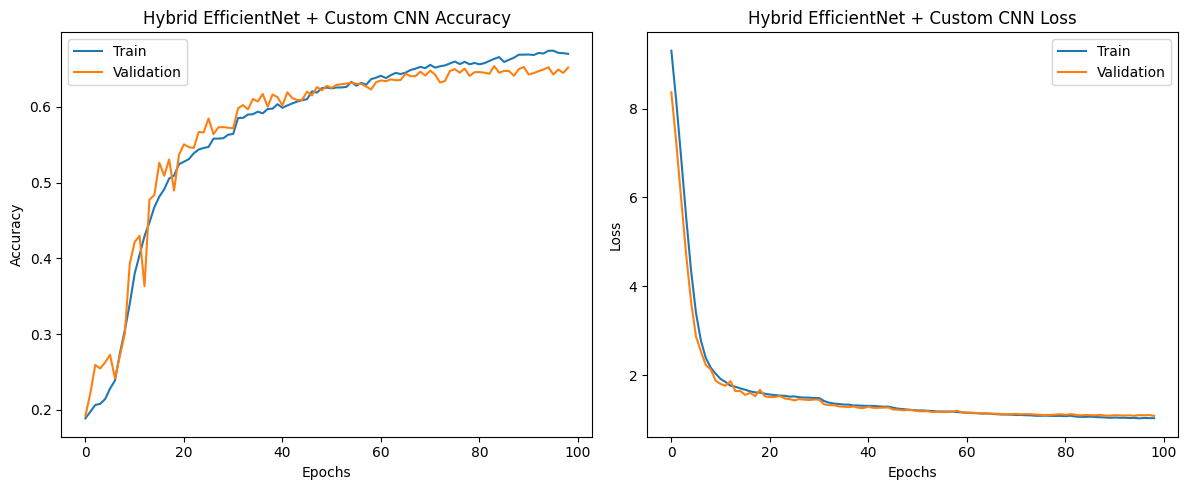

221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step


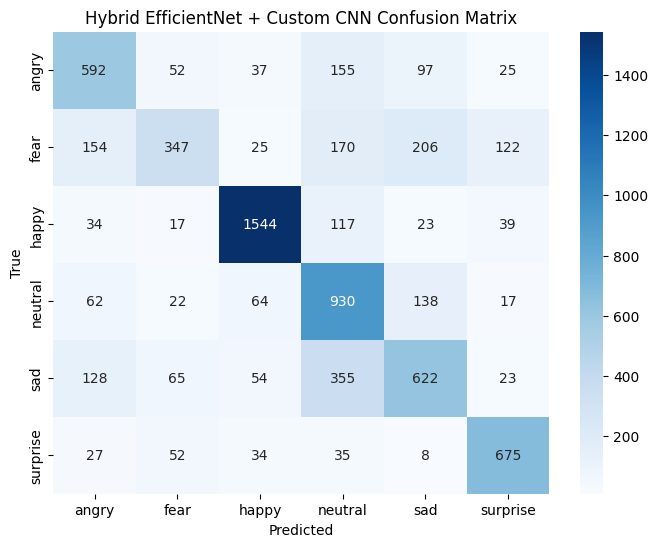


Classification Report (Hybrid EfficientNet + Custom CNN):

              precision    recall  f1-score   support

       angry       0.59      0.62      0.61       958
        fear       0.63      0.34      0.44      1024
       happy       0.88      0.87      0.87      1774
     neutral       0.53      0.75      0.62      1233
         sad       0.57      0.50      0.53      1247
    surprise       0.75      0.81      0.78       831

    accuracy                           0.67      7067
   macro avg       0.66      0.65      0.64      7067
weighted avg       0.67      0.67      0.66      7067

✅ Hybrid EfficientNet + Custom CNN model saved!



In [ ]:
# ==============================================
# 1️⃣ Train and Evaluate Hybrid EfficientNet + Custom CNN Model
# ==============================================

print("\n" + "="*60)
print("TRAINING HYBRID EFFICIENTNET + CUSTOM CNN MODEL")
print("="*60)

# Callbacks (same as before)
checkpoint = ModelCheckpoint(
    "best_hybrid_efficientnet_custom_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

# Build and compile the model
hybrid_model = model_hybrid_efficientnet_custom(
    input_shape=(48, 48, 1),
    num_classes=len(SELECTED_CLASSES),
    efficientnet_weights='imagenet',
    freeze_base=True,
    unfreeze_last_n=20,
    l2_reg=0.01
)

hybrid_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_hybrid = hybrid_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
histories['hybrid_efficientnet_custom'] = history_hybrid

# Evaluate on test data
test_loss, test_acc = hybrid_model.evaluate(test_generator, verbose=0)
results['hybrid_efficientnet_custom'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nHybrid EfficientNet + Custom CNN - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['accuracy'], label='Train')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation')
plt.title("Hybrid EfficientNet + Custom CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['loss'], label='Train')
plt.plot(history_hybrid.history['val_loss'], label='Validation')
plt.title("Hybrid EfficientNet + Custom CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report
pred_hybrid = hybrid_model.predict(test_generator)
y_pred_hybrid = np.argmax(pred_hybrid, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_hybrid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Hybrid EfficientNet + Custom CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (Hybrid EfficientNet + Custom CNN):\n")
print(classification_report(y_true, y_pred_hybrid, target_names=class_labels))

# Save model
hybrid_model.save("fer_hybrid_efficientnet_custom_model.h5")
print("✅ Hybrid EfficientNet + Custom CNN model saved!\n")


In [7]:
# Store training histories and results for comparison at the end
histories = {}
results = {}

# ResNet50V2 base + Custom CNN

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (
    Input, Lambda, Conv2D, BatchNormalization, MaxPool2D, Dropout,
    Flatten, Dense, Concatenate, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

def model_hybrid_resnetv2_custom(input_shape, num_classes,
                                 resnet_weights='imagenet',
                                 freeze_base=True,
                                 unfreeze_last_n=20,
                                 l2_reg=0.01):
    """
    Hybrid model combining ResNet50V2 (pretrained) with a custom CNN branch.

    Parameters:
    - input_shape: tuple, e.g. (48,48,1)
    - num_classes: int, e.g. 7
    - resnet_weights: 'imagenet' or None
    - freeze_base: whether to freeze ResNet base initially
    - unfreeze_last_n: number of ResNet layers to unfreeze for fine-tuning
    - l2_reg: regularization for deep conv layers

    Returns:
    - Keras Model object
    """

    # ----- Input + grayscale → 3-channel conversion -----
    inputs = Input(shape=input_shape)
    if input_shape[-1] == 1:
        x3 = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)
    else:
        x3 = inputs

    # ----- Pretrained ResNet50V2 branch -----
    base_model = ResNet50V2(
        weights=resnet_weights,
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )
    resnet_out = base_model(x3)
    resnet_out = GlobalAveragePooling2D()(resnet_out)

    # ----- Custom CNN branch (your CNN architecture) -----
    c = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    c = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    c = Conv2D(128, kernel_size=(5,5), padding='same', activation='relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    c = Conv2D(512, kernel_size=(3,3), padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(l2_reg))(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    c = Conv2D(512, kernel_size=(3,3), padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(l2_reg))(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2,2))(c)
    c = Dropout(0.25)(c)

    c = Flatten()(c)
    c = Dense(256, activation='relu')(c)
    c = BatchNormalization()(c)
    c = Dropout(0.25)(c)
    c = Dense(512, activation='relu')(c)
    c = BatchNormalization()(c)
    c = Dropout(0.25)(c)

    # ----- Merge pretrained + custom features -----
    merged = Concatenate()([resnet_out, c])

    # ----- Classification head -----
    x = Dense(512, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # ----- Fine-tuning control -----
    if freeze_base:
        base_model.trainable = False
    else:
        base_model.trainable = True

    if unfreeze_last_n and unfreeze_last_n > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-unfreeze_last_n]:
            layer.trainable = False
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    return model



TRAINING HYBRID RESNET50V2 + CUSTOM CNN MODEL
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1958 - loss: 9.4921
Epoch 1: val_accuracy improved from -inf to 0.29077, saving model to best_hybrid_resnetv2_custom_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 99s 93ms/step - accuracy: 0.1958 - loss: 9.4910 - val_accuracy: 0.2908 - val_loss: 8.1509 - learning_rate: 1.0000e-04
Epoch 2/100
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2428 - loss: 8.0925
Epoch 2: val_accuracy improved from 0.29077 to 0.30810, saving model to best_hybrid_resnetv2_custom_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.2428 - loss: 8.0915 - val_accuracy: 0.3081 - val_loss: 6.7606 - learning_rate: 1.0000e-04
Epoch 3/100
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2588 - loss: 6.6262
Epoch 3: val_accuracy improved from 0.30810 to 0.32579, saving model to best_hybrid_resnetv2_custom_model.keras
707/707 ━━━

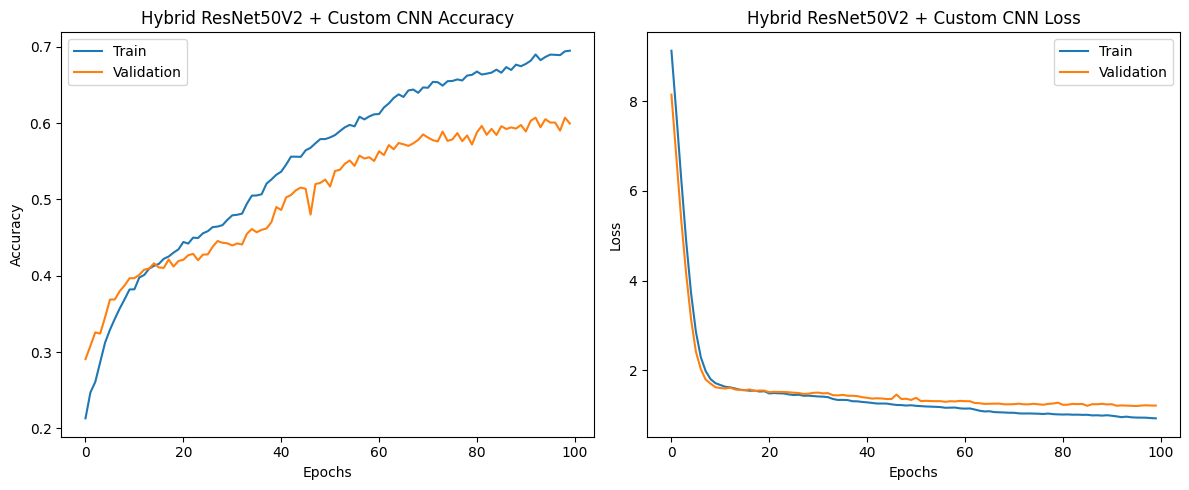

221/221 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step


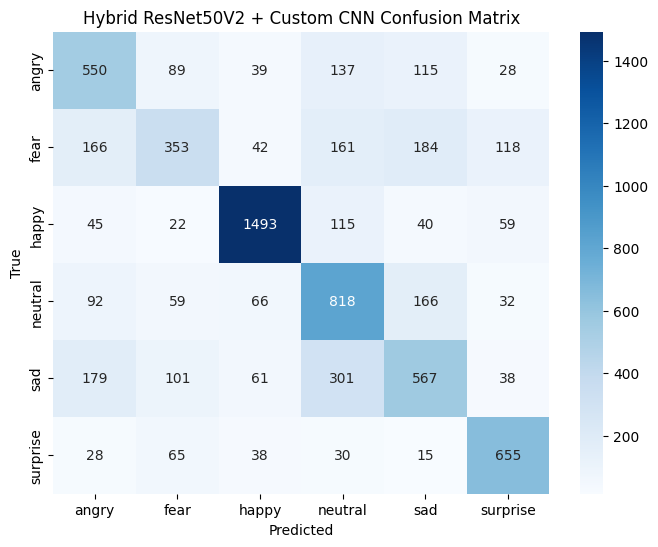


Classification Report (Hybrid ResNet50V2 + Custom CNN):

              precision    recall  f1-score   support

       angry       0.52      0.57      0.55       958
        fear       0.51      0.34      0.41      1024
       happy       0.86      0.84      0.85      1774
     neutral       0.52      0.66      0.59      1233
         sad       0.52      0.45      0.49      1247
    surprise       0.70      0.79      0.74       831

    accuracy                           0.63      7067
   macro avg       0.61      0.61      0.60      7067
weighted avg       0.63      0.63      0.62      7067

✅ Hybrid ResNet50V2 + Custom CNN model saved!



In [ ]:
# ==============================================
# 2️⃣ Train and Evaluate Hybrid ResNet50V2 + Custom CNN Model
# ==============================================

print("\n" + "="*60)
print("TRAINING HYBRID RESNET50V2 + CUSTOM CNN MODEL")
print("="*60)

# Callbacks
checkpoint = ModelCheckpoint(
    "best_hybrid_resnetv2_custom_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

# Build and compile model
hybrid_resnet_model = model_hybrid_resnetv2_custom(
    input_shape=(48, 48, 1),
    num_classes=len(SELECTED_CLASSES),
    resnet_weights='imagenet',
    freeze_base=True,
    unfreeze_last_n=20,
    l2_reg=0.01
)

hybrid_resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history_hybrid_resnet = hybrid_resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)
histories['hybrid_resnetv2_custom'] = history_hybrid_resnet

# Evaluate model
test_loss, test_acc = hybrid_resnet_model.evaluate(test_generator, verbose=0)
results['hybrid_resnetv2_custom'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nHybrid ResNet50V2 + Custom CNN - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Accuracy & Loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid_resnet.history['accuracy'], label='Train')
plt.plot(history_hybrid_resnet.history['val_accuracy'], label='Validation')
plt.title("Hybrid ResNet50V2 + Custom CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_hybrid_resnet.history['loss'], label='Train')
plt.plot(history_hybrid_resnet.history['val_loss'], label='Validation')
plt.title("Hybrid ResNet50V2 + Custom CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix and classification report
pred_hybrid_resnet = hybrid_resnet_model.predict(test_generator)
y_pred_hybrid_resnet = np.argmax(pred_hybrid_resnet, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_hybrid_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Hybrid ResNet50V2 + Custom CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (Hybrid ResNet50V2 + Custom CNN):\n")
print(classification_report(y_true, y_pred_hybrid_resnet, target_names=class_labels))

# Save model
hybrid_resnet_model.save("fer_hybrid_resnetv2_custom_model.h5")
print("✅ Hybrid ResNet50V2 + Custom CNN model saved!\n")


# VGG16 + CUSTOM CNN

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, Lambda, Conv2D, BatchNormalization, MaxPool2D, Dropout,
    GlobalAveragePooling2D, Flatten, Dense, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf


def model_hybrid_vgg16_custom(input_shape, num_classes,
                              vgg_weights='imagenet',
                              freeze_base=True,
                              unfreeze_last_n=4,
                              l2_reg=0.01):
    """
    Hybrid model: VGG16 (pretrained) + custom CNN branch.
    - input_shape: tuple, e.g. (48, 48, 1)
    - num_classes: integer (e.g. 7)
    - vgg_weights: 'imagenet' or None
    - freeze_base: if True, freezes the pretrained VGG16 layers
    - unfreeze_last_n: number of last layers to unfreeze for fine-tuning
    - l2_reg: L2 regularization factor for deeper conv layers

    Returns:
        Compilable Keras Model (not compiled)
    """

    # ----- Input + Grayscale Conversion -----
    inputs = Input(shape=input_shape)
    if input_shape[-1] == 1:
        x3 = Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)
    else:
        x3 = inputs

    # ----- VGG16 Branch -----
    base_model = VGG16(
        weights=vgg_weights,
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    vgg_out = base_model(x3)
    vgg_out = GlobalAveragePooling2D()(vgg_out)

    # ----- Custom CNN Branch -----
    c = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    c = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2, 2))(c)
    c = Dropout(0.25)(c)

    c = Conv2D(128, kernel_size=(5, 5), padding='same', activation='relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2, 2))(c)
    c = Dropout(0.25)(c)

    c = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(l2_reg))(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2, 2))(c)
    c = Dropout(0.25)(c)

    c = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu',
               kernel_regularizer=regularizers.l2(l2_reg))(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(pool_size=(2, 2))(c)
    c = Dropout(0.25)(c)

    c = Flatten()(c)
    c = Dense(256, activation='relu')(c)
    c = BatchNormalization()(c)
    c = Dropout(0.25)(c)

    c = Dense(512, activation='relu')(c)
    c = BatchNormalization()(c)
    c = Dropout(0.25)(c)

    # ----- Feature Fusion -----
    merged = Concatenate()([vgg_out, c])

    # ----- Classifier Head -----
    x = Dense(512, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # ----- Fine-tuning Logic -----
    if freeze_base:
        base_model.trainable = False
    else:
        base_model.trainable = True

    if unfreeze_last_n and unfreeze_last_n > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-unfreeze_last_n]:
            layer.trainable = False
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    return model


In [9]:
print("Building hybrid VGG16 + Custom CNN model...")
vgg16_hybrid_model = model_hybrid_vgg16_custom((48,48,1), 7)
vgg16_hybrid_model.compile(optimizer=Adam(1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])


Building hybrid VGG16 + Custom CNN model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



TRAINING HYBRID VGG16 + CUSTOM CNN MODEL
Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2215 - loss: 9.5149
Epoch 1: val_accuracy improved from -inf to 0.31447, saving model to best_hybrid_vgg16_custom_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 87s 90ms/step - accuracy: 0.2215 - loss: 9.5144 - val_accuracy: 0.3145 - val_loss: 8.5356 - learning_rate: 1.0000e-04
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3025 - loss: 8.3097
Epoch 2: val_accuracy did not improve from 0.31447
707/707 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.3025 - loss: 8.3093 - val_accuracy: 0.2361 - val_loss: 8.6829 - learning_rate: 1.0000e-04
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3465 - loss: 7.0249
Epoch 3: val_accuracy did not improve from 0.31447
707/707 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.3465 - loss: 7.0244 - val_accuracy: 0.2871 - val_loss: 6.3228 - learning_rate: 1.0000e-04
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 5

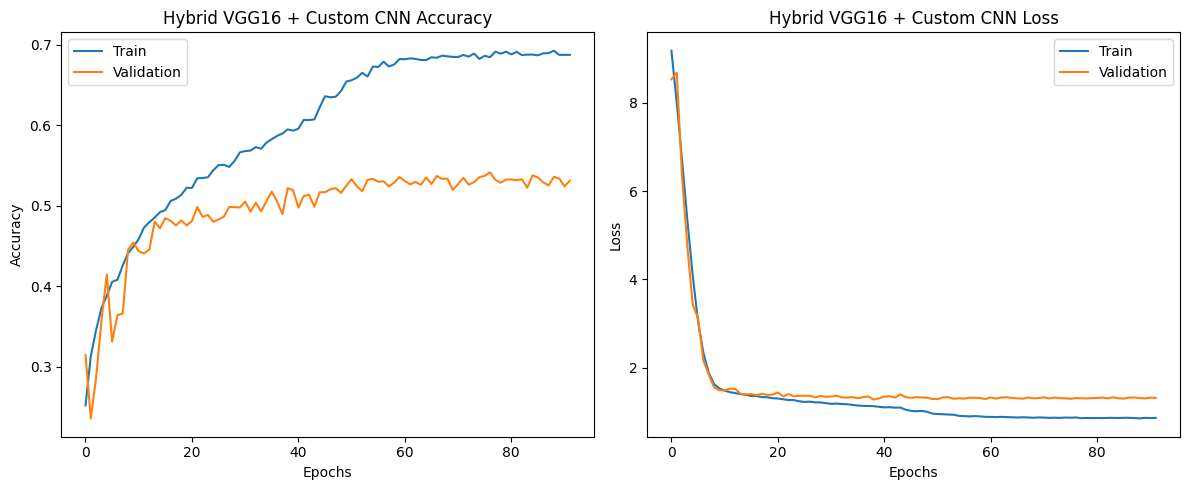

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


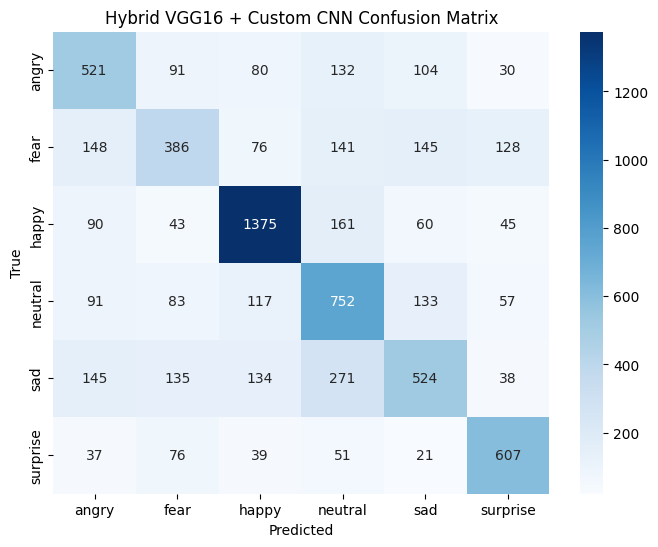


Classification Report (Hybrid VGG16 + Custom CNN):

              precision    recall  f1-score   support

       angry       0.50      0.54      0.52       958
        fear       0.47      0.38      0.42      1024
       happy       0.76      0.78      0.76      1774
     neutral       0.50      0.61      0.55      1233
         sad       0.53      0.42      0.47      1247
    surprise       0.67      0.73      0.70       831

    accuracy                           0.59      7067
   macro avg       0.57      0.58      0.57      7067
weighted avg       0.59      0.59      0.58      7067

✅ Hybrid VGG16 + Custom CNN model saved successfully!



In [11]:
# ==============================================
# 1️⃣ Train and Evaluate Hybrid VGG16 + Custom CNN Model
# ==============================================

print("\n" + "="*60)
print("TRAINING HYBRID VGG16 + CUSTOM CNN MODEL")
print("="*60)

# Define callbacks
checkpoint = ModelCheckpoint(
    "best_hybrid_vgg16_custom_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
callbacks = [checkpoint, early_stop, reduce_lr]

# ---- Initialize & Compile Model ----
vgg16_hybrid_model = model_hybrid_vgg16_custom(
    input_shape=(48, 48, 1),
    num_classes=6,
    vgg_weights='imagenet',
    freeze_base=True,          # start with frozen VGG base
    unfreeze_last_n=4,         # fine-tune last 4 layers later
    l2_reg=0.01
)

vgg16_hybrid_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ---- Train Model ----
history_vgg16_hybrid = vgg16_hybrid_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Store training history
histories['hybrid_vgg16_custom'] = history_vgg16_hybrid

# ---- Evaluate on Test Data ----
test_loss, test_acc = vgg16_hybrid_model.evaluate(test_generator, verbose=0)
results['hybrid_vgg16_custom'] = {'accuracy': test_acc, 'loss': test_loss}
print(f"\nHybrid VGG16 + Custom CNN - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# ---- Accuracy & Loss Curves ----
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vgg16_hybrid.history['accuracy'], label='Train')
plt.plot(history_vgg16_hybrid.history['val_accuracy'], label='Validation')
plt.title("Hybrid VGG16 + Custom CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16_hybrid.history['loss'], label='Train')
plt.plot(history_vgg16_hybrid.history['val_loss'], label='Validation')
plt.title("Hybrid VGG16 + Custom CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ---- Confusion Matrix and Classification Report ----
pred_vgg16_hybrid = vgg16_hybrid_model.predict(test_generator)
y_pred_vgg16_hybrid = np.argmax(pred_vgg16_hybrid, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_vgg16_hybrid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Hybrid VGG16 + Custom CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (Hybrid VGG16 + Custom CNN):\n")
print(classification_report(y_true, y_pred_vgg16_hybrid, target_names=class_labels))

# ---- Save Model ----
vgg16_hybrid_model.save("fer_hybrid_vgg16_custom_model.h5")
print("✅ Hybrid VGG16 + Custom CNN model saved successfully!\n")
